## Vectors and Topics for Fun
### Document classification with Gensim

In this tutorial we'll classify movie plots by genre using word embeddings techniques in [gensim](http://radimrehurek.com/gensim/) . 

See accompanying slides in this repo.

We will show how to get a __'hello-world'__ first untuned run using 7 techniques:

- Bag of words

- Character n-grams

- TF-IDF 

- Averaging word2vec vectors

- doc2vec

- Deep IR 

- Word Mover's Distance

The goal of this tutorial is to show the API so you can start tuning them yourself. Model tuning of the models is out of scope of this tutorial.

We will also compare the accuracy of this first 'no tuning'/out of the box run of these techniques. It is in no way an indication of their best peformance that can be achieved with proper tuning. The benefit of the comparison is to manage the expectations.

## Requirements
- Python 3
- [Google News pre-trained word2vec (1.5 GB)](https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit?usp=sharing)
- gensim
- sklearn
- pandas
- matplotlib
- nltk with English stopwords
- pyemd
- 4 GB RAM
- 8 GB disk space for WMD

## Dataset
We will use MovieLens dataset linked with plots from OMDB. Thanks to [Sujit Pal](http://sujitpal.blogspot.de/2016/04/predicting-movie-tags-from-plots-using.html) for this linking idea. The prepared csv is in this repository. If you wish to link the datasets yourself - see the code in the [blog]((http://sujitpal.blogspot.de/2016/04/predicting-movie-tags-from-plots-using.html).

In [3]:
import logging
logging.root.handlers = []  # Jupyter messes up logging so needs a reset
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
from smart_open import smart_open
import pandas as pd
import numpy as np
from numpy import random
import gensim
import nltk
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from sklearn.neighbors import KNeighborsClassifier
from sklearn import linear_model
from nltk.corpus import stopwords
nltk.download('punkt')

%matplotlib inline

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Ihab\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Exploring the data



In [4]:
df = pd.read_csv('data/tagged_plots_movielens.csv')
df = df.dropna()
df['plot'].apply(lambda x: len(x.split(' '))).sum()

171156

The dataset is only __170k__ words. It is quite small but makes sure we don't have to wait a long time for the code to complete.

<AxesSubplot:>

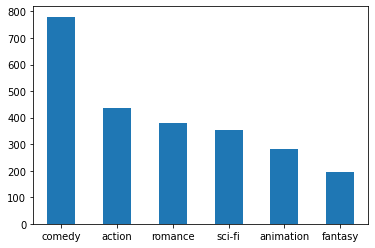

In [5]:
my_tags = ['sci-fi' , 'action', 'comedy', 'fantasy', 'animation', 'romance']
df.tag.value_counts().plot(kind="bar", rot=0)

The data is very unbalanced. We have Comedy as majority class. 

A naive classifier that predicts everything to be comedy already achieves __40%__ accuracy.

The language in sci-fi plots differs a lot from action plots, so there should be some signal here.

In [6]:
df


,Unnamed: 0,movieId,plot,tag
0,0,1,A little boy named Andy loves to be in his roo...,animation
1,1,2,When two kids find and play a magical board ga...,fantasy
2,2,3,Things don't seem to change much in Wabasha Co...,comedy
3,3,6,Hunters and their prey--Neil and his professio...,action
4,4,7,An ugly duckling having undergone a remarkable...,romance
...,...,...,...,...
2443,2443,148618,Three kids who travel back in time to 65 milli...,animation
2444,2444,148624,"Top Cat and the gang face a new police chief, ...",animation
2445,2445,149088,Raggedy Ann and the rest of the toys in Marcel...,animation
2446,2446,149406,"Continuing his ""legendary adventures of awesom...",comedy


In [7]:
def print_plot(index):
    example = df[df.index == index][['plot', 'tag']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Genre:', example[1])

In [8]:
print_plot(12)

In a future world devastated by disease, a convict is sent back in time to gather information about the man-made virus that wiped out most of the human population on the planet.
Genre: sci-fi


In [9]:
print_plot(15)

Based on the popular video game of the same name "Mortal Kombat" tells the story of an ancient tournament where the best of the best of different Realms fight each other. The goal - ten wins to be able to legally invade the losing Realm. Outworld has so far collected nine wins against Earthrealm, so it's up to Lord Rayden and his fighters to stop Outworld from reaching the final victory...
Genre: action


Train/test split of 90/10

In [10]:
train_data, test_data = train_test_split(df, test_size=0.1, random_state=42)

In [11]:
len(test_data)

243

<AxesSubplot:>

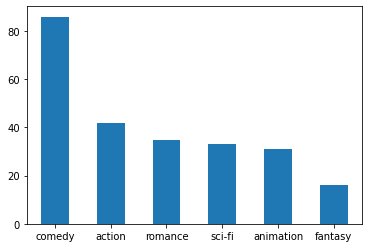

In [12]:
test_data.tag.value_counts().plot(kind="bar", rot=0)

## Model evaluation approach
We will use confusion matrices to evaluate all classifiers

In [13]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(my_tags))
    target_names = my_tags
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [14]:
def evaluate_prediction(predictions, target, title="Confusion matrix"):
    print('accuracy %s' % accuracy_score(target, predictions))
    cm = confusion_matrix(target, predictions)
    print('confusion matrix\n %s' % cm)
    print('(row=expected, col=predicted)')
    
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plot_confusion_matrix(cm_normalized, title + ' Normalized')

In [15]:
def predict(vectorizer, classifier, data):
    data_features = vectorizer.transform(data['plot'])
    predictions = classifier.predict(data_features)
    target = data['tag']
    evaluate_prediction(predictions, target)

## Baseline: bag of words, n-grams, tf-idf
Let's start with some simple baselines before diving into more advanced methods.

### Bag of words

The simplest document feature is just a count of each word occurrence in a document.

We remove stop-words and use NLTK tokenizer then limit our vocabulary to 3k most frequent words.

In [16]:
def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) < 2:
                continue
            tokens.append(word.lower())
    return tokens

In [17]:
%%time
# training
count_vectorizer = CountVectorizer(
    analyzer="word", tokenizer=nltk.word_tokenize,
    preprocessor=None, stop_words='english', max_features=3000) 

train_data_features = count_vectorizer.fit_transform(train_data['plot'])
train_data_features

Wall time: 1.73 s


<2184x3000 sparse matrix of type '<class 'numpy.int64'>'
	with 54806 stored elements in Compressed Sparse Row format>

Multi-modal logistic regression is a simple white-box classifier. We will use either logistic regression or KNN throughout this tutorial.

In [16]:
%%time

logreg = linear_model.LogisticRegression(n_jobs=1, C=1e5)
logreg = logreg.fit(train_data_features, train_data['tag'])

AttributeError: 'str' object has no attribute 'decode'

In [17]:
count_vectorizer.get_feature_names()[80:90]

['advanced',
 'advantage',
 'adventure',
 'adventures',
 'adventurous',
 'advice',
 'affair',
 'affairs',
 'affect',
 'afraid']

Nothing impressive - only 2% better better than the classifier that thinks that everything is a comedy.

In [18]:
%%time

predict(count_vectorizer, logreg, test_data)

AttributeError: 'list' object has no attribute 'shape'

White box vectorizer and classifier are great! We can see what are the most important words for sci-fi. This makes it very easy to tune and debug.

In [19]:
def most_influential_words(vectorizer, genre_index=0, num_words=10):
    features = vectorizer.get_feature_names()
    max_coef = sorted(enumerate(logreg.coef_[genre_index]), key=lambda x:x[1], reverse=True)
    return [features[x[0]] for x in max_coef[:num_words]]    

In [20]:
# words for the fantasy genre
genre_tag_id = 1
print(my_tags[genre_tag_id])
most_influential_words(count_vectorizer, genre_tag_id)

action


IndexError: list index out of range

In [ ]:
train_data_features[0]

### Character N-grams

A character _n-gram_ is a chunk of a document of length _n_. It is a poor man's tokenizer but sometimes works well. The parameter _n_ depends on language and the corpus. We choose length between 3 and 6 characters and to only focus on 3k most popular ones.

In [ ]:
%%time
n_gram_vectorizer = CountVectorizer(
    analyzer="char",
    ngram_range=([2,5]),
    tokenizer=None,    
    preprocessor=None,                               
    max_features=3000) 

logreg = linear_model.LogisticRegression(n_jobs=1, C=1e5)

train_data_features = n_gram_vectorizer.fit_transform(train_data['plot'])

logreg = logreg.fit(train_data_features, train_data['tag'])

In [ ]:
n_gram_vectorizer.get_feature_names()[50:60]

The results are worse than using a tokenizer and bag of words. Probably due to not removing the stop words.

In [ ]:
predict(n_gram_vectorizer, logreg, test_data)

### TF-IDF

[Term Frequency - Inverse Document Frequency](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) is a little more advanced way to count words in a document.
It adjusts for document length, word frequency and most importantly for frequency of a particular word in a particular document.


In [ ]:
%%time
tf_vect = TfidfVectorizer(
    min_df=2, tokenizer=nltk.word_tokenize,
    preprocessor=None, stop_words='english')
train_data_features = tf_vect.fit_transform(train_data['plot'])

logreg = linear_model.LogisticRegression(n_jobs=1, C=1e5)
logreg = logreg.fit(train_data_features, train_data['tag'])

In [ ]:
tf_vect.get_feature_names()[1000:1010]

In [ ]:
predict(tf_vect, logreg, test_data)

White box vectorizer and classifier are great! We can see what are the most important words for sci-fi. This makes it very easy to tune and debug.

In [ ]:
most_influential_words(tf_vect, 1)

### Things to try with bag of words

10 mins for exercises.

For more insight into the model print out the most influential words for a particular plot.

Try n-grams with TF-IDF.



# Averaging word vectors

Now let's use more complex features rather than just counting words.

A great recent achievement of NLP is the [word2vec embedding](https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf). See Chris Moody's [video](https://www.youtube.com/watch?v=vkfXBGnDplQ) for a great introduction to word2vec. 


First we load a word2vec model. It has been pre-trained by Google on a 100 billon word Google News corpus. You can play with this model using a fun [web-app](http://rare-technologies.com/word2vec-tutorial/#app).

Link to the web-app: http://rare-technologies.com/word2vec-tutorial/#app

Vocabulary size: 3 mln words. 

__Warning__: 3 mins to load, takes 4 GB of RAM.

In [ ]:
%%time
from gensim.scripts.glove2word2vec import glove2word2vec
import os
glove2word2vec(glove_input_file="data\\vectors.50.txt", word2vec_output_file="data\gensim_glove_vectors.txt")
wv = gensim.models.KeyedVectors.load_word2vec_format( "data\gensim_glove_vectors.txt", binary=False)
os.remove('data\gensim_glove_vectors.txt')
wv.init_sims(replace=True)

In [ ]:
wv.vector_size

Example vocabulary

In [ ]:
from itertools import islice
list(islice(wv.vocab, 13000, 13020))

Now we have a vector for each word. How do we get a vector for a sequence of words (aka a document)?




The most naive way is just to take an average. [Mike Tamir](https://www.youtube.com/watch?v=7gTjYwiaJiU) has suggested that the resulting vector points to a single word summarising the whole document. For example all words in a book
 ‘A tale of two cities’ should add up to 'class-struggle’

<img src="images/naivedoc2vec.png">

In [ ]:

def word_averaging(wv, words):
    all_words, mean = set(), []
    
    for word in words:
        if isinstance(word, np.ndarray):
            mean.append(word)
        elif word in wv.vocab:
            mean.append(wv.syn0norm[wv.vocab[word].index])
            all_words.add(wv.vocab[word].index)

    if not mean:
        logging.warning("cannot compute similarity with no input %s", words)
        # FIXME: remove these examples in pre-processing
        return np.zeros(wv.layer1_size,)

    mean = gensim.matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32)
    return mean

def  word_averaging_list(wv, text_list):
    return np.vstack([word_averaging(wv, review) for review in text_list ])

For word2vec we apply a different tokenization. We want to preserve case as the vocabulary distingushes lower and upper case.

In [ ]:
def w2v_tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text, language='english'):
        for word in nltk.word_tokenize(sent, language='english'):
            if len(word) < 2:
                continue
            tokens.append(word)
    return tokens

In [ ]:
test_tokenized = test_data.apply(lambda r: w2v_tokenize_text(r['plot']), axis=1).values
train_tokenized = train_data.apply(lambda r: w2v_tokenize_text(r['plot']), axis=1).values

In [ ]:
%%time
X_train_word_average = word_averaging_list(wv,train_tokenized)
X_test_word_average = word_averaging_list(wv,test_tokenized)

Let's see how KNN and logistic regression classifiers perform on these word-averaging document features.

In [ ]:
%%time
knn_naive_dv = KNeighborsClassifier(n_neighbors=3, n_jobs=1, algorithm='brute', metric='cosine' )
knn_naive_dv.fit(X_train_word_average, train_data.tag)


In [ ]:
%%time
predicted = knn_naive_dv.predict(X_test_word_average)

In [ ]:
evaluate_prediction(predicted, test_data.tag)

KNN is even worse than the naive 'everything is comedy' baseline! Let's see if logistic regression is better.

In [ ]:
%%time
logreg = linear_model.LogisticRegression(n_jobs=1, C=1e5)

logreg = logreg.fit(X_train_word_average, train_data['tag'])
predicted = logreg.predict(X_test_word_average)

Great! It gives __54%__ accuracy. Best that we have seen so far.

In [ ]:
evaluate_prediction(predicted, test_data.tag)

Now just for fun let's see if text summarisation works on our data. Let's pick a plot and see which words it averages to.

In [ ]:
test_data.iloc()[56]['plot']

Hmm... The summarisation doesn't work here. Any ideas why? Hint: look at the area where the average ends up.

In [ ]:
wv.most_similar(positive=[X_test_word_average[56]], restrict_vocab=100000, topn=30)[0:20]

### Word2vec things to try

10 mins exercise

Remove stop-words. 




In [ ]:


def w2v_tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text, language='english'):
        for word in nltk.word_tokenize(sent, language='english'):
            if len(word) < 2:
                continue
            if word in stopwords.words('english'):
                continue
            tokens.append(word)
    return tokens

### What accuracy do you get?

In [ ]:
### More word2vec things to try

Experiment with other pre-trained models - see nice [list](https://github.com/3Top/word2vec-api/) from 3Top.


Use Gensim's GloVe converter.


Do IDF weighting in the averaging function.

# Doc2Vec

A [paper](https://cs.stanford.edu/~quocle/paragraph_vector.pdf) by Google suggests a model for document classification called Paragraph Vectors Doc2Vec or Doc2vec in short. It is very similar to word2vec. 

It introduces 'a tag' - a word that is in every context in the document.

For our first try we tag every plot with its genre. This makes it 'semi-supervised' learning - the genre labels is just one objective among many.

In [ ]:
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument

In [ ]:
train_tagged = train_data.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['plot']), tags=[r.tag]), axis=1)

In [ ]:
test_tagged = test_data.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['plot']), tags=[r.tag]), axis=1)

This is what a training entry looks like - an example plot tagged by 'sci-fi'.

In [ ]:
test_tagged.values[50]

In [ ]:
%%time
trainsent = train_tagged.values
testsent = test_tagged.values

# simple gensim doc2vec api
doc2vec_model = Doc2Vec(trainsent, workers=1, size=5, iter=20, dm=1)

train_targets, train_regressors = zip(
    *[(doc.tags[0], doc2vec_model.infer_vector(doc.words, steps=20)) for doc in trainsent])

Interesting thing about doc2vec is that we need to run gradient descent during prediction to infer the vector for an unseen document. An unseen document is initially assigned a random vector and then this vector fit by gradient descent. Because of this randomness we get different vectors on re-runs of the next cell.

Consequently, the accuracy of logistic regression changes when the test set vectors change.

In [ ]:
%%time
test_targets, test_regressors = zip(
    *[(doc.tags[0], doc2vec_model.infer_vector(doc.words, steps=20)) for doc in testsent])

In [ ]:
logreg = linear_model.LogisticRegression(n_jobs=1, C=1e5)
logreg = logreg.fit(train_regressors, train_targets)
evaluate_prediction(logreg.predict(test_regressors), test_targets, title=str(doc2vec_model))

KNN gives a lower accuracy than logistic regression.

In [ ]:
%%time 
knn_test_predictions = [
    doc2vec_model.docvecs.most_similar([pred_vec], topn=1)[0][0]
    for pred_vec in test_regressors
]
evaluate_prediction(knn_test_predictions, test_targets, str(doc2vec_model))

Doc2vec gives us a vector for each genre so we can see which genres are close together.

In [ ]:
doc2vec_model.docvecs.most_similar('action')

Words surrounding the 'sci-fi' tag describe it pretty accurately!

In [ ]:
doc2vec_model.most_similar([doc2vec_model.docvecs['sci-fi']])

### Doc2vec exercise

10 mins

Find the random seed that gives the best prediction. :)



In [ ]:
seed = 20

doc2vec_model.seed = seed
doc2vec_model.random = random.RandomState(seed)


test_targets, test_regressors = zip(
    *[(doc.tags[0], doc2vec_model.infer_vector(doc.words, steps=20)) for doc in testsent])


logreg = linear_model.LogisticRegression(n_jobs=1, C=1e5, random_state=42)
logreg = logreg.fit(train_regressors, train_targets)
evaluate_prediction(logreg.predict(test_regressors), test_targets, title=str(doc2vec_model))
print(doc2vec_model.seed)

## Doc2vec things to try
Try tagging every sentence with a unique tag 'SENT_123' and then apply KNN. 

Try multiple tags per plot as in this repo published __today__ : https://github.com/sindbach/doc2vec_pymongo



# Deep IR

'Deep IR' is a technique developed by  [“Document Classification by Inversion of Distributed Language Representations”, Matt Taddy](http://arxiv.org/pdf/1504.07295v3.pdf). Matt has contributed a gensim [tutorial](https://github.com/piskvorky/gensim/blob/develop/docs/notebooks/deepir.ipynb) - great source of more in depth information.

In short the algorithm is:

1. Train a word2vec model only on comedy plots.

2. Trian another model only on sci-fi, another on romance etc. Get 6 models - one for each genre.

3. Take a plot and see which model fits it best using Bayes' Theorem



The tokenization is different from other methods. The reason for this is that we are following an original approach in the paper. The purpose of this tutorial is to see how the models behave out of the box.

We just clean non-alphanumeric characters and split by sentences.

In [ ]:
import re
contractions = re.compile(r"'|-|\"")
# all non alphanumeric
symbols = re.compile(r'(\W+)', re.U)
# single character removal
singles = re.compile(r'(\s\S\s)', re.I|re.U)
# separators (any whitespace)
seps = re.compile(r'\s+')

# cleaner (order matters)
def clean(text): 
    text = text.lower()
    text = contractions.sub('', text)
    text = symbols.sub(r' \1 ', text)
    text = singles.sub(' ', text)
    text = seps.sub(' ', text)
    return text

# sentence splitter
alteos = re.compile(r'([!\?])')
def sentences(l):
    l = alteos.sub(r' \1 .', l).rstrip("(\.)*\n")
    return l.split(".")


In [ ]:
def plots(label):
    my_df = None
    if label=='training':
        my_df = train_data
    else:
        my_df = test_data
    for i, row in my_df.iterrows():
        yield {'y':row['tag'],\
        'x':[clean(s).split() for s in sentences(row['plot'])]}


In [ ]:
%%time
# The corpus is small so can be read into memory
revtrain = list(plots("training"))
revtest = list(plots("test"))

In [ ]:
# shuffle training set for unbiased word2vec training
np.random.shuffle(revtrain)

In [ ]:
def tag_sentences(reviews, stars=my_tags):  
    for r in reviews:
        if r['y'] in stars:
            for s in r['x']:
                yield s

An example `sci-fi` sentence:

In [ ]:
next(tag_sentences(revtrain, my_tags[0]))

We train our own 6 word2vec models from scratch. 

In [ ]:
%%time 
## training
from gensim.models import Word2Vec
import multiprocessing

## create a w2v learner 
basemodel = Word2Vec(
    workers=multiprocessing.cpu_count(), # use your cores
    iter=100, # iter = sweeps of SGD through the data; more is better
    hs=1, negative=0, # we only have scoring for the hierarchical softmax setup
    
    )
print(basemodel)
basemodel.build_vocab(tag_sentences(revtrain)) 
from copy import deepcopy
genremodels = [deepcopy(basemodel) for i in range(len(my_tags))]
for i in range(len(my_tags)):
    slist = list(tag_sentences(revtrain, my_tags[i]))
    print(my_tags[i], "genre (", len(slist), ")")
    genremodels[i].train( slist, total_examples=len(slist) ,epochs = basemodel.epochs)
# get the probs (note we give docprob a list of lists of words, plus the models)


Now we will compute most likely class for a plot using Bayes' Theorem formula.

<img src='images/deep_ir_bayes.png' width=600>

For any new sentence we can obtain its _likelihood_ (lhd; actually, the composite likelihood approximation; see the paper) using the [score](https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.Word2Vec.score) function in the `word2vec` class.  We get the likelihood for each sentence in the first test review, then convert to a probability over star ratings. Every sentence in the review is evaluated separately and the final star rating of the review is an average vote of all the sentences. This is all in the following handy wrapper. (from the original [tutorial](https://github.com/piskvorky/gensim/blob/develop/docs/notebooks/deepir.ipynb) by Matt Taddy.

In [ ]:
"""
docprob takes two lists
* docs: a list of documents, each of which is a list of sentences
* models: the candidate word2vec models (each potential class)

it returns the array of class probabilities.  Everything is done in-memory.
"""


def docprob(docs, mods):
    # score() takes a list [s] of sentences here; could also be a sentence generator
    sentlist = [s for d in docs for s in d]
    # the log likelihood of each sentence in this review under each w2v representation
    llhd = np.array( [ m.score(sentlist, len(sentlist)) for m in mods ] )
    # now exponentiate to get likelihoods, 
    lhd = np.exp(llhd - llhd.max(axis=0)) # subtract row max to avoid numeric overload
    # normalize across models (stars) to get sentence-star probabilities
    prob = pd.DataFrame( (lhd/lhd.sum(axis=0)).transpose() )
    # and finally average the sentence probabilities to get the review probability
    prob["doc"] = [i for i,d in enumerate(docs) for s in d]
    prob = prob.groupby("doc").mean()
    return prob

In [ ]:
%%time
## predict
probs = docprob( [r['x'] for r in revtest], genremodels )  
predictions = probs.idxmax(axis=1).apply(lambda x: my_tags[x])

In [ ]:
tag_index = 0
col_name = "out-of-sample prob positive for " + my_tags[tag_index]
probpos = pd.DataFrame({col_name:probs[[tag_index]].sum(axis=1), 
                        "true genres": [r['y'] for r in revtest]})
probpos.boxplot(col_name,by="true genres", figsize=(12,5))

In [ ]:
target = [r['y'] for r in revtest]

In [ ]:
evaluate_prediction(predictions, target, "Deep IR with word2vec")

Performance is worse than for a naive predictor that says that everything is `comedy`.

### Why?



It is because we train each word2vec model from scratch on a very small sample of about 30k words.

This model needs more data.

# Conclusion

Above we shown how to run 'hello-world' in 7 different document classification techniques. It is just a beginning of exploration of their features... There are a lot of parameters that can be tuned to get the best possible results out of them. The 'hello-world' run is in no way an indication of their best peformance. The goal of this tutorial is to show the API so you can start tuning them yourself.

Out of the box "no tuning" accuracy of bag of words is not far behind more advanced techniques. 
Tune them and the pre-processing for them well first and only then reach for more advanced methods if more accuracy is absolutely needed.